In [148]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
combine = [train, test]

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## pclass

클래스별 생존 히스토그램

C:\Users\NaEunSu\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


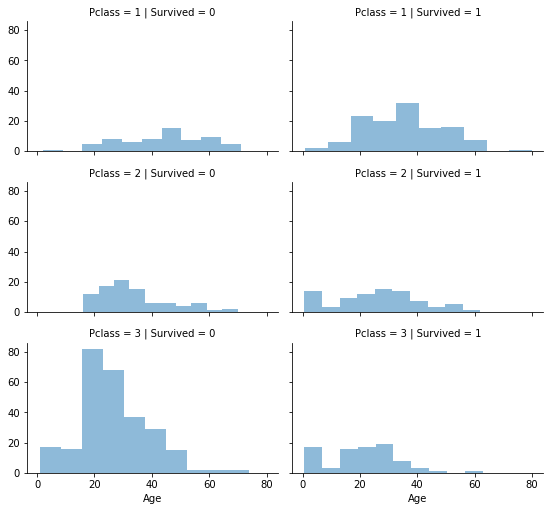

In [4]:
grid = sns.FacetGrid(train, row="Pclass", col="Survived", size=2.4, aspect=1.6)
grid.map(plt.hist, "Age", alpha=0.5, bins=10)
grid.add_legend();

In [5]:
for data in combine:
    data.Pclass = data.Pclass.astype("category")

## Name

In [6]:
pat = re.compile("(.+)(, )([\w]+)(.+)")
# train_appellation = []
# test_appellation = []

for data in combine:
    appellation = []
    for i in data.Name.values:
        appellation.append(pat.sub("\g<3>",i))
    data["호칭"] = appellation

호칭과 성별의 관계를 보자

In [7]:
train_name_sex = pd.crosstab(train["호칭"],train["Sex"]).T
train_name_sex.style.background_gradient(cmap='RdBu')

호칭,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the
Sex,,,,,,,,,,,,,,,,,
female,0,0,0,1,0,1,0,0,182,2,1,0,125,1,0,0,1
male,1,2,1,6,1,0,2,40,0,0,0,517,0,0,6,1,0


기타 호칭을 etc로 구분하자

In [8]:
train_name_sex.keys()

Index(['Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master',
       'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the'],
      dtype='object', name='호칭')

In [9]:
for data in combine:
    data.호칭.replace(['Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major',
                       'Rev', 'Sir', 'the',"Dona"], "etc", inplace=True)
    data.호칭.replace({"Mlle":"Miss", "Ms":"Miss", "Mme":"Mrs"}, inplace=True)

In [10]:
train.groupby("호칭").mean()

,PassengerId,Survived,Age,SibSp,Parch,Fare
호칭,,,,,,
Master,414.975000,0.575000,4.574167,2.300000,1.375000,34.703125
Miss,411.967568,0.702703,21.845638,0.702703,0.540541,43.800092
Mr,454.499033,0.156673,32.368090,0.288201,0.152805,24.441560
Mrs,452.500000,0.793651,35.788991,0.690476,0.825397,45.330290
etc,547.043478,0.347826,45.545455,0.347826,0.086957,37.169748


남자를 나타내는 호칭이 생존률이 제일적다. 어린아이인 Master, 숙녀,부인을 나타내는 Miss,Mrs의 생존률은 높다.

호칭의 문자열 데이터를 수치형으로 바꿔주자

In [11]:
for data in combine:
    data.호칭.replace({"Master":0, "Miss":1, "Mr":2, "Mrs":3, "etc":4}, inplace=True)

### Sex

Sex열도 문자열이기 때문에 수치형으로 바꿔주자

In [12]:
for data in combine:
    data.Sex.replace({"female":1,"male":0},inplace=True)

## SibSp, Parch

SibSp: 형제, 배우자의 수

Parch: 부모의 수

두 컬럼이 나타내는 공통은 가족의 수를 나타내므로 두 컬럼을 합쳐보자

In [13]:
for data in combine:
    data["Family_size"] = data["SibSp"]+data["Parch"]+1 # 1을 더하는 이유는 본인도 넣어주기 위함

가족의 수에 따른 생존율을 보자

In [14]:
train.groupby("Family_size").mean()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,호칭
Family_size,,,,,,,,
1,458.000000,0.303538,0.234637,32.220297,0.000000,0.000000,21.242689,1.906890
2,412.838509,0.552795,0.540373,31.391511,0.763975,0.236025,49.894129,2.211180
3,448.352941,0.578431,0.480392,26.035806,0.872549,1.127451,39.692482,1.813725
4,514.344828,0.724138,0.655172,18.274815,1.344828,1.655172,54.864510,1.689655
5,367.866667,0.200000,0.800000,20.818182,2.133333,1.866667,58.094453,1.333333
6,400.136364,0.136364,0.363636,18.409091,2.818182,2.181818,73.722727,1.181818
7,355.750000,0.333333,0.666667,15.166667,3.250000,2.750000,29.366667,1.166667
8,393.833333,0.000000,0.333333,15.666667,4.333333,2.666667,46.900000,1.000000
11,481.714286,0.000000,0.428571,NaN,8.000000,2.000000,69.550000,1.285714


4인가족이하의 생존율이 가장 높고 그 다음은 혼자인 사람 그러고 5인이상인 대가족의 생존율은 낮은것을 확인

그렇다면 가족의 수를 세가지의 구간으로 나눠서 수치데이터로 바꿔주자

In [15]:
for data in combine:
        data["Family_size"] = np.where(data.Family_size==1, 0,
                np.where(data.Family_size<5,1,2))

In [16]:
train.Family_size.value_counts()

0    537
1    292
2     62
Name: Family_size, dtype: int64

## age

In [17]:
# train.isna().sum()
# age의 결측치 177개 확인

C:\Users\NaEunSu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age'>

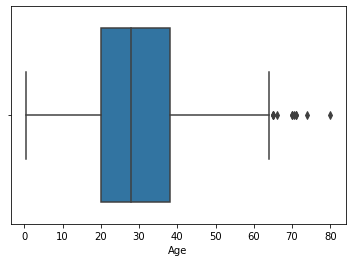

In [18]:
sns.boxplot(train["Age"])

In [19]:
train.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

대부분의 나이는 20~40사이에 있는것을 확인.

우리는 위에서 확인한 호칭에서 나이를 유추할 수 있다. 호칭에 따른 나이의 평균을 살펴보자

In [20]:
train.groupby("호칭").mean()[["Age"]]

,Age
호칭,
0,4.574167
1,21.845638
2,32.368090
3,35.788991
4,45.545455


호칭과 pclass로 구분하여 나이의 평균도 보자

In [21]:
train.groupby(["호칭","Pclass"]).mean()[["Age"]]

Age
호칭 Pclass           
0  1        5.306667
   2        2.258889
   3        5.350833
1  1       29.744681
   2       22.560606
   3       16.123188
2  1       41.580460
   2       32.768293
   3       28.724891
3  1       40.400000
   2       33.682927
   3       33.515152
4  1       47.571429
   2       42.000000
   3             NaN

C:\Users\NaEunSu\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\NaEunSu\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 52845 missing from current font.
  font.set_text(s, 0.0, flags=flags)


C:\Users\NaEunSu\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\NaEunSu\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 52845 missing from current font.
  font.set_text(s, 0, flags=flags)


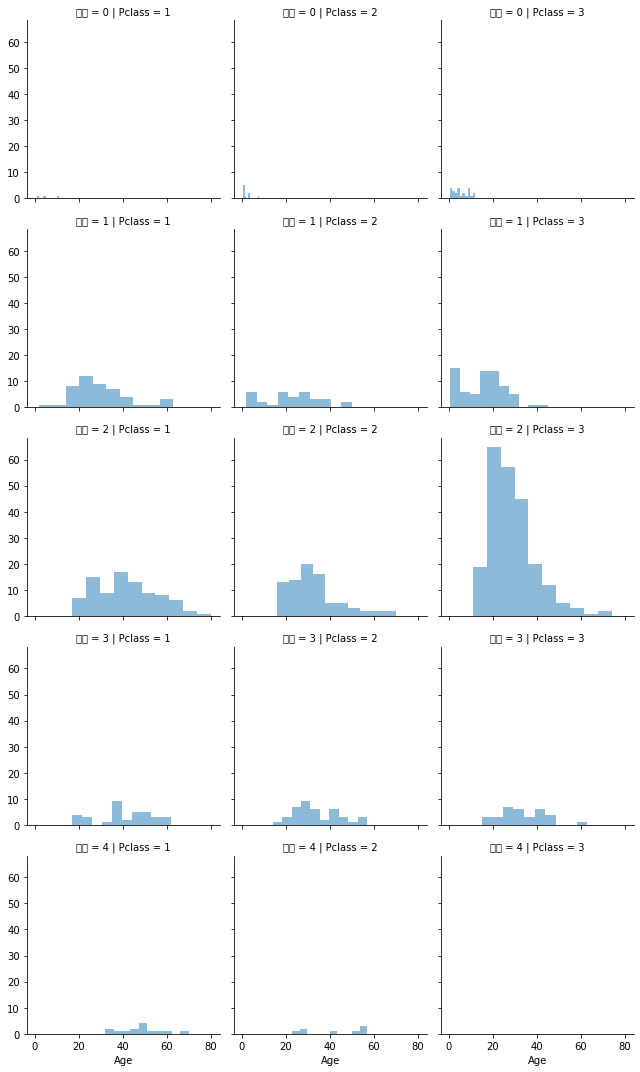

In [22]:
grid = sns.FacetGrid(train, row="호칭",col="Pclass")
grid.map(plt.hist, "Age", alpha=0.5, bins=10)

pclass가 높을수록 나이의 평균도 높은것을 확인.

그런데 pclass3에서 분포가 20~40살에 몰려있으므로 최빈값을 넣어주도록 하자

또한 호칭4의 경우 pclass가 3인 사람이 없으므로 호칭 4의경우만 평균치를 넣어주도록하자

In [23]:
guess_ages = np.zeros((5,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [24]:
for data in combine:
    for i in range(0,5):
        for j in range(0,3):
            if i < 4:
                guess_df = data[(data["호칭"]==i) & \
                               (data["Pclass"]==j+1)]["Age"].dropna()
        #             print(guess_df)
                age_guess = guess_df.median()
        #             print(age_guess)
                guess_ages[i,j] = int(age_guess+0.5)
            else:
                guess_df = data[data["호칭"]==i]["Age"].dropna()
                age_guess = guess_df.mean()
#                 print(age_guess)
                guess_ages[i,j] = int(age_guess+0.5)
            
    for i in range(0,5):
        for j in range(0,3):
            data.loc[(data.Age.isna()) & (data["호칭"]==i) & (data.Pclass==j+1),\
                     "Age"] = guess_ages[i,j]

In [25]:
guess_ages

array([[10.,  5.,  7.],
       [32., 20., 22.],
       [42., 28., 25.],
       [48., 29., 28.],
       [44., 44., 44.]])

(array([ 58.,  46., 212., 278., 146.,  71.,  45.,  24.,   9.,   2.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <BarContainer object of 10 artists>)

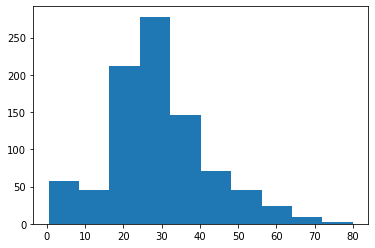

In [26]:
plt.hist(train["Age"])

age 열을 구간으로 나눠주자

In [27]:
train["Age_band"] = pd.cut(train["Age"],5)
train.groupby("Age_band").mean()[["Survived"]]

,Survived
Age_band,
"(0.34, 16.336]",0.548077
"(16.336, 32.252]",0.336735
"(32.252, 48.168]",0.410138
"(48.168, 64.084]",0.434783
"(64.084, 80.0]",0.090909


In [28]:
for data in combine:
    data["Age"] = np.where(data["Age"] <= 17, 0,
                          np.where(data["Age"]<=32,1,
                              np.where(data["Age"]<=48,2,
                                      np.where(data["Age"]<=64,3,4))))

## Fare

(array([732., 106.,  31.,   2.,  11.,   6.,   0.,   0.,   0.,   3.]),
 array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
        307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
 <BarContainer object of 10 artists>)

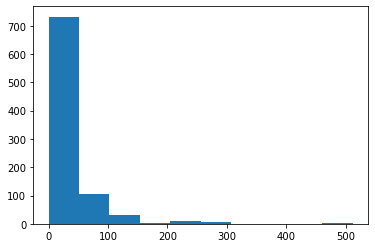

In [29]:
plt.hist(train["Fare"])

C:\Users\NaEunSu\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


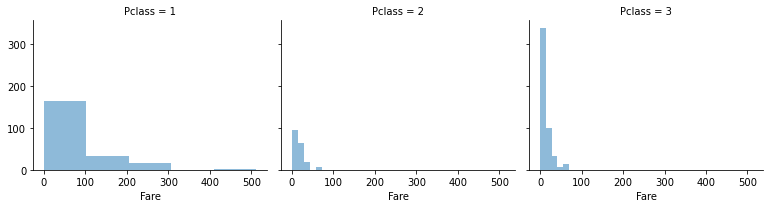

In [30]:
grid = sns.FacetGrid(train, col="Pclass", size= 3, aspect=1.2)
grid.map(plt.hist, "Fare", alpha=0.5, bins=5)

In [31]:
train.groupby("Pclass").mean()["Fare"]

Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64

Fare열의 분포도 구간으로 나눠주자

In [32]:
train["Fare_band"] = pd.qcut(train.Fare, 4)
train.groupby("Fare_band").mean()[["Survived"]]

,Survived
Fare_band,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


구간을 3,4,5 로 나눈결과 4가 적절해보임

In [33]:
for data in combine:
    data.Fare = np.where(data.Fare<7.91, 0,
                        np.where(data.Fare<14.454, 1,
                                np.where(data.Fare<31,2,3)))

## Embarked

train의 Embarked열의 결측치 2개는 최빈값으로 채워주자

In [34]:
train.Embarked.fillna(train.Embarked.mode()[0],inplace=True)

Embarked열을 수치형으로 바꿔주자

In [35]:
for data in combine:
    data.Embarked.replace({"S":0,"C":1,"Q":2}, inplace=True)

### 이제 필요없는 컬럼들을 제거하자

In [36]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,호칭,Family_size,Age_band,Fare_band
0,1,0,3,"Braund, Mr. Owen Harris",0,1,1,0,A/5 21171,0,NaN,0,2,1,"(16.336, 32.252]","(-0.001, 7.91]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,PC 17599,3,C85,1,3,1,"(32.252, 48.168]","(31.0, 512.329]"
2,3,1,3,"Heikkinen, Miss. Laina",1,1,0,0,STON/O2. 3101282,1,NaN,0,1,0,"(16.336, 32.252]","(7.91, 14.454]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,113803,3,C123,0,3,1,"(32.252, 48.168]","(31.0, 512.329]"
4,5,0,3,"Allen, Mr. William Henry",0,2,0,0,373450,1,NaN,0,2,0,"(32.252, 48.168]","(7.91, 14.454]"


In [37]:
train.drop(["PassengerId","Name","Ticket","Cabin","Age_band","Fare_band"], axis=1, inplace=True)

test.drop(["PassengerId","Name","Ticket","Cabin"], axis=1, inplace=True)

In [38]:
train.drop(["SibSp","Parch"], axis=1, inplace=True)
test.drop(["SibSp","Parch"], axis=1, inplace=True)

In [39]:
train = pd.get_dummies(train, columns=["Embarked","Family_size","호칭"])
test = pd.get_dummies(test, columns=["Embarked","Family_size","호칭"])

In [40]:
train

,Survived,Pclass,Sex,Age,Fare,Embarked_0,Embarked_1,Embarked_2,Family_size_0,Family_size_1,Family_size_2,호칭_0,호칭_1,호칭_2,호칭_3,호칭_4
0,0,3,0,1,0,1,0,0,0,1,0,0,0,1,0,0
1,1,1,1,2,3,0,1,0,0,1,0,0,0,0,1,0
2,1,3,1,1,1,1,0,0,1,0,0,0,1,0,0,0
3,1,1,1,2,3,1,0,0,0,1,0,0,0,0,1,0
4,0,3,0,2,1,1,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,1,1,1,0,0,1,0,0,0,0,0,0,1
887,1,1,1,1,2,1,0,0,1,0,0,0,1,0,0,0
888,0,3,1,1,2,1,0,0,0,1,0,0,1,0,0,0
889,1,1,0,1,2,0,1,0,1,0,0,0,0,1,0,0


In [42]:
train.shape, test.shape

((891, 16), (418, 15))

In [43]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked_0,Embarked_1,Embarked_2,Family_size_0,Family_size_1,Family_size_2,호칭_0,호칭_1,호칭_2,호칭_3,호칭_4
0,0,3,0,1,0,1,0,0,0,1,0,0,0,1,0,0
1,1,1,1,2,3,0,1,0,0,1,0,0,0,0,1,0
2,1,3,1,1,1,1,0,0,1,0,0,0,1,0,0,0
3,1,1,1,2,3,1,0,0,0,1,0,0,0,0,1,0
4,0,3,0,2,1,1,0,0,1,0,0,0,0,1,0,0


## Modeling

In [44]:
X = train.drop("Survived",axis=1)
y = train["Survived"]

In [166]:
X.shape, y.shape, test.shape

((891, 15), (891,), (418, 15))

In [339]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1001)

In [340]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1001)

### 교차검증

In [341]:
model_list = [KNeighborsClassifier(),DecisionTreeClassifier(),RandomForestClassifier(),AdaBoostClassifier()]

In [342]:
def cross_score(model, X_train, y_train):
    scores = []
    for i in range(10):
        score = cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy")
        scores.append(score.mean())
    return scores

In [343]:
for i in model_list:
    print(np.mean(cross_score(i,X,y)), i)

0.8159550561797753 KNeighborsClassifier()
0.8058676654182273 DecisionTreeClassifier()
0.8130274656679152 RandomForestClassifier()
0.8193008739076154 AdaBoostClassifier()


Adaboost, RandomForest의 정확도가 제일 높아보인다.

### 파리미터 튜닝

random forest

In [381]:
rf_model = RandomForestClassifier()

rf_par_grid = {"n_estimators":[100,300],
               ""
               "max_features": [1, 3, 5],
              "min_samples_split":[2,5,7],
              "min_samples_leaf":[1,2,4]}

In [404]:
gsRFC = GridSearchCV(rf_model, param_grid=rf_par_grid, cv = 10, scoring="accuracy",n_jobs= -1, verbose = 1)
gsRFC.fit(X,y)

RFC_best = gsRFC.best_estimator_
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.83167290886392

In [409]:
RFC_best

RandomForestClassifier(max_features=5, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=300)

In [406]:
gsRFC.best_params_

{'max_features': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 300}

In [407]:
accuracy_score(gsRFC.predict(X_test),y_test)

0.8324022346368715

In [410]:
rf_pred = RFC_best.predict(test)

In [411]:
test2["Survived"] = rf_pred
sub = test2[["PassengerId","Survived"]]
sub.to_csv("titanic_1004_rf.csv",index=False)

adaboost

In [356]:
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=1001)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[5,10],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

In [359]:
gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=10, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,y_train)
ADA_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


0.8215766823161189

In [360]:
gsadaDTC.best_params_

{'algorithm': 'SAMME',
 'base_estimator__criterion': 'entropy',
 'base_estimator__splitter': 'random',
 'learning_rate': 1.5,
 'n_estimators': 10}

In [361]:
accuracy_score(gsadaDTC.predict(X_test),y_test)

0.770949720670391

In [213]:
ada_pred = ADA_best.predict(test)

### knn

In [299]:
scores= []
for k in range(3,20,2):
    score = cross_val_score(KNeighborsClassifier(n_neighbors=k), X,y, cv=10, scoring="accuracy")
    scores.append([score.mean(),k])
scores

[[0.7968913857677903, 3],
 [0.8148689138576779, 5],
 [0.811498127340824, 7],
 [0.8227465667915107, 9],
 [0.8238701622971286, 11],
 [0.8182397003745319, 13],
 [0.826079900124844, 15],
 [0.826067415730337, 17],
 [0.8226966292134831, 19]]

In [319]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
accuracy_score(knn_model.predict(X_test),y_test)

0.8156424581005587

In [386]:
pred = knn_model.predict(test)
test2["Survived"] = pred
sub = test2[["PassengerId","Survived"]]
sub.to_csv("titanic_1004_just.csv",index=False)

decisionTree

In [391]:
dt_model = DecisionTreeClassifier()

dt_par_grid = {"max_depth":[5,6,7,8],
              "min_samples_split":[2,5,7],
              "min_samples_leaf":[1,2,4]}

In [397]:
gsDT = GridSearchCV(dt_model,param_grid = dt_par_grid, cv=10, scoring="accuracy", n_jobs= -1, verbose = 1)

gsDT.fit(X,y)
DT_best = gsDT.best_estimator_
gsDT.best_score_

Fitting 10 folds for each of 36 candidates, totalling 360 fits


0.8272034956304619

In [398]:
gsDT.best_params_

{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5}

In [402]:
accuracy_score(gsDT.predict(X_test),y_test)

0.8212290502793296

In [403]:
accuracy_score(gsadaDTC.predict(X_test),y_test)

0.770949720670391

In [401]:
pred = gsDT.predict(test)
test2["Survived"] = pred
sub = test2[["PassengerId","Survived"]]
sub.to_csv("titanic_1004_dt.csv",index=False)

vote

In [214]:
votingC = VotingClassifier(estimators=[("rfc",RFC_best),("adac",ADA_best)], voting="soft")
votingC.fit(X,y)

VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(max_features=1,
                                                     min_samples_leaf=3,
                                                     min_samples_split=7)),
                             ('adac',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.01,
                                                 n_estimators=2,
                                                 random_state=7))],
                 voting='soft')

In [216]:
voting_pred = votingC.predict(test)

In [217]:
test2 = pd.read_csv("data/test.csv")
test2["Survived"]=rf_pred

sub = test2[["PassengerId","Survived"]]
sub.to_csv("titanic_rf.csv", index=False)

dt(depth:8)

In [412]:
model = DecisionTreeClassifier(max_depth=8)
model.fit(X,y)
pred = model.predict(test)

In [413]:
test2 = pd.read_csv("data/test.csv")
test2["Survived"]=pred

sub = test2[["PassengerId","Survived"]]
sub.to_csv("titanic_1004_dt_2.csv", index=False)

In [414]:
model = RandomForestClassifier()
model.fit(X_train,y_train)
accuracy_score(model.predict(X_))

,Pclass,Sex,Age,Fare,Embarked_0,Embarked_1,Embarked_2,Family_size_0,Family_size_1,Family_size_2,호칭_0,호칭_1,호칭_2,호칭_3,호칭_4
0,3,0,1,0,1,0,0,0,1,0,0,0,1,0,0
1,1,1,2,3,0,1,0,0,1,0,0,0,0,1,0
2,3,1,1,1,1,0,0,1,0,0,0,1,0,0,0
3,1,1,2,3,1,0,0,0,1,0,0,0,0,1,0
4,3,0,2,1,1,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,0,1,1,1,0,0,1,0,0,0,0,0,0,1
887,1,1,1,2,1,0,0,1,0,0,0,1,0,0,0
888,3,1,1,2,1,0,0,0,1,0,0,1,0,0,0
889,1,0,1,2,0,1,0,1,0,0,0,0,1,0,0
